Imports + initialize tpu/gpu

In [1]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    GCS_PATH = 'gs://kds-730dfb73e90bcfe94bba623cbc90984df476fa507c3e44b785ea223e/'
except:
    print('WARNING: Not connected to a TPU runtime')
    strategy = tf.distribute.get_strategy()
    GCS_PATH = ''

Import Pneumonia Dataset (from google store for tpu) + set variables (batch, epoch, image size, tune)

In [2]:
filenames = tf.io.gfile.glob(str(GCS_PATH + 'chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + 'chest_xray/val/*/*')))
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMG_SIZE = 224
EPOCHS = 15

Functions for processing images

In [3]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Use buffered prefetching so we can yield data from disk without having I/O blocking

In [4]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Load + Process train/test data

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(tf.data.Dataset.from_tensor_slices(train_filenames)).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(tf.data.Dataset.from_tensor_slices(val_filenames)).numpy()

In [6]:
test_ds = tf.data.Dataset.list_files(str(GCS_PATH + 'chest_xray/test/*/*')).map(process_path, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

train_ds = prepare_for_training(tf.data.Dataset.from_tensor_slices(train_filenames).map(process_path, num_parallel_calls=AUTOTUNE))
val_ds = prepare_for_training(tf.data.Dataset.from_tensor_slices(val_filenames).map(process_path, num_parallel_calls=AUTOTUNE))

image_batch, label_batch = next(iter(train_ds))

2022-03-02 21:14:40.890021: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-02 21:14:43.335229: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Data was imbalanced, with more images classified as pneumonia than normal. Each normal image will be weighted more to balance the data as the CNN works best when the training data is balanced.

In [7]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

Retrain moblenetv2 model for use with dataset (transfer learning).

Since there are only two possible labels for the image, we will be using the `binary_crossentropy` loss. When we fit the model, identify the class weights. Because we are using a TPU, training will be relatively quick.

In [8]:
with strategy.scope():
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
    base_model.trainable = False
    model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1),
    ])
    model.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )
    
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=int((EPOCHS/3)*2),
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/10
261/261 [==============================] - 41s 143ms/step - loss: 1.7606 - accuracy: 0.7979 - val_loss: 0.7541 - val_accuracy: 0.9173
Epoch 2/10
261/261 [==============================] - 30s 117ms/step - loss: 1.0314 - accuracy: 0.9023 - val_loss: 0.6002 - val_accuracy: 0.9260
Epoch 3/10
261/261 [==============================] - 30s 116ms/step - loss: 0.8422 - accuracy: 0.9035 - val_loss: 0.8685 - val_accuracy: 0.9096
Epoch 4/10
261/261 [==============================] - 30s 116ms/step - loss: 0.8436 - accuracy: 0.9097 - val_loss: 0.3502 - val_accuracy: 0.9490
Epoch 5/10
261/261 [==============================] - 30s 116ms/step - loss: 1.0752 - accuracy: 0.8721 - val_loss: 0.7015 - val_accuracy: 0.9288
Epoch 6/10
261/261 [==============================] - 30s 115ms/step - loss: 0.7554 - accuracy: 0.9277 - val_loss: 0.5954 - val_accuracy: 0.9462
Epoch 7/10
261/261 [==============================] - 30s 115ms/step - loss: 7.2370 - accuracy: 0.3020 - val_loss: 11.2672 - val_a

In [9]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight
)

Epoch 10/15
261/261 [==============================] - 46s 173ms/step - loss: 6.3835 - accuracy: 0.7759 - val_loss: 1.3164 - val_accuracy: 0.8990
Epoch 11/15
261/261 [==============================] - 45s 174ms/step - loss: 1.8791 - accuracy: 0.9059 - val_loss: 1.2586 - val_accuracy: 0.9115
Epoch 12/15
261/261 [==============================] - 45s 174ms/step - loss: 2.0659 - accuracy: 0.9023 - val_loss: 1.3762 - val_accuracy: 0.8981
Epoch 13/15
261/261 [==============================] - 45s 173ms/step - loss: 1.7679 - accuracy: 0.9162 - val_loss: 1.1852 - val_accuracy: 0.9144
Epoch 14/15
261/261 [==============================] - 45s 174ms/step - loss: 1.4465 - accuracy: 0.9246 - val_loss: 0.9757 - val_accuracy: 0.9308
Epoch 15/15
261/261 [==============================] - 45s 172ms/step - loss: 1.2061 - accuracy: 0.9265 - val_loss: 0.9703 - val_accuracy: 0.9337


Plot Results

Text(0.5, 1.0, 'Training and Validation Accuracy')

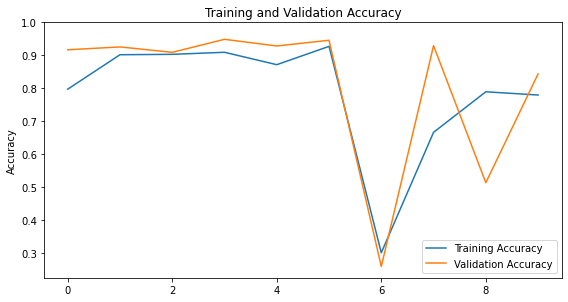

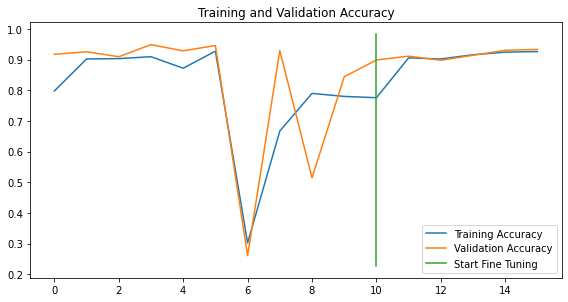

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8), tight_layout=True)
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

plt.figure(figsize=(8, 8), tight_layout=True)
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([int((EPOCHS/3)*2),int((EPOCHS/3)*2)],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Convert model to TFLite

In [11]:
def representative_data_gen():
    dataset_list = tf.data.Dataset.list_files(GCS_PATH + "chest_xray/train/*/*")
    for i in range(100):
        path = next(iter(dataset_list))
        file_bytes = tf.io.read_file(path)
        img = tf.io.decode_jpeg(file_bytes, channels=3)
        img = tf.cast(img, tf.float32) / 255.0 
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = tf.expand_dims(img, 0)
        yield [img]
        
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model_quant = converter.convert()

with open('xray_mobilenetv2_quant_model.tflite', 'wb') as f:
    f.write(tflite_model_quant)
    
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
output_type = interpreter.get_output_details()[0]['dtype']
print('input: ', input_type)
print('output: ', output_type)

2022-03-02 21:24:30.576830: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/vf/7353c1ls6wzg4gqk6f49zjn00000gn/T/tmp3jv6i34i/assets


INFO:tensorflow:Assets written to: /var/folders/vf/7353c1ls6wzg4gqk6f49zjn00000gn/T/tmp3jv6i34i/assets
/Users/shauryasingh/miniforge3/envs/edgetpu/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-03-02 21:24:59.880586: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-03-02 21:24:59.880600: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-03-02 21:24:59.881483: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/vf/7353c1ls6wzg4gqk6f49zjn00000gn/T/tmp3jv6i34i
2022-03-02 21:24:59.899227: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-03-02 21:24:59.899242: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel d

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


Google's edgeTPU compiler only works on linux, and only on x86_64 at that. Lets spin up a docker container to get that working run `docker build --platform linux/amd64 --tag edgetpu_compiler https://github.com/tomassams/docker-edgetpu-compiler.git` if you haven't already

In [12]:
!docker run -it --platform linux/amd64 --rm -v (pwd):/home/edgetpu edgetpu_compiler edgetpu_compiler --min_runtime_version 13 xray_mobilenetv2_quant_model.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 7281 ms.

Input model: xray_mobilenetv2_quant_model.tflite
Input size: 2.59MiB
Output model: xray_mobilenetv2_quant_model_edgetpu.tflite
Output size: 2.79MiB
On-chip memory used for caching model parameters: 2.71MiB
On-chip memory remaining for caching model parameters: 4.99MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 70
Operation log: xray_mobilenetv2_quant_model_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 
